# Import

In [1]:
import pandas as pd
import os, torch
from utils.utils import align_predictions
from exp.plot_config import *
from data.data_factory import AgeData
from exp.config import Split

# Setting

In [36]:
from run import *
argv = """
--data_path Top_20.csv --model FEDformer
""".split()
parser = get_parser()
args = parser.parse_args(argv)
print(args)

setting = stringify_setting(args)

Namespace(test=False, model='FEDformer', seed=7, root_path='./dataset/processed/', data_path='Top_20.csv', result_path='results', freq='d', no_scale=False, seq_len=14, label_len=7, pred_len=14, top_k=5, num_kernels=6, d_model=64, n_heads=4, e_layers=2, d_layers=1, d_ff=256, moving_avg=7, factor=3, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, num_workers=0, train_epochs=10, batch_size=32, patience=3, learning_rate=0.001, des='', loss='MSE', lradj='type1', use_amp=False, no_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3', p_hidden_dims=[64, 64], p_hidden_layers=2, disable_progress=False)


# Load data

In [37]:
age_data = AgeData.build(args)
total_data = age_data.read_df()
train, val, test, updated = age_data.split_data(
    total_data, Split.primary()
)

adding time index columns TimeFromStart
added time encoded known reals ['month', 'day', 'weekday'].

Train samples 12740, validation samples 560,             test samples 560, last samples 7980
637 days of training, 14 days of validation data,             14 days of test data and 385 of data after test start.

Fitting scalers on train data


In [38]:
flag = 'test'
dataset_root = os.path.join(DataConfig.root_folder, args.data_path.split('.')[0])
path = os.path.join(dataset_root, f'{flag}.pt')
ts_dataset = None
if os.path.exists(path):
    print(f'Loading dataset from {path}')
    ts_dataset = torch.load(path)

dataset, dataloader = age_data.create_tslib_timeseries(
    data=test, train=False, 
    ts_dataset=ts_dataset # using a cached dataset help speeding up
)

Loading dataset from ./dataset/processed\Top_20\test.pt


In [39]:
time_index = age_data.time_index
age_features = age_data.static_reals
past_features = age_data.static_reals + age_data.observed_reals
known_features = age_data.known_reals

predictions_index = pd.DataFrame(
    dataset.ranges, 
    columns=age_data.group_ids + [time_index]
)
predictions_index[time_index] += args.pred_len + test[time_index].min()

# Attribution

## Load 

In [40]:
# (past_features, know_futures)
explainer_name = 'feature_ablation'
attr_file = f"{args.result_path}/{args.model}_{args.data_path.split('.')[0]}/interpretation/{flag}_{explainer_name}.pt"
attr = torch.load(attr_file)

# attribution of the past features
# attr = attr[0]

## Global importance

In [124]:
past_feature_importance = attr[0].mean(axis=(0, 1, 2))
time_known_feature_importance = attr[1].mean(axis=(0, 1, 2))
feature_imp = np.concatenate([past_feature_importance, time_known_feature_importance], axis=0)
print(feature_imp)

feature_imp_normalized = feature_imp *100 / (feature_imp.sum())
print(feature_imp_normalized)

[0.59399384 0.59999067 0.66006935 0.62018454 0.65095675 0.576091
 0.65933406 0.58867526 0.5498319  5.263734   0.5781403  0.6220069
 0.57601005]
[ 4.7371635  4.784989   5.264123   4.9460373  5.1914487  4.5943866
  5.258259   4.6947474  4.384968  41.978836   4.61073    4.960571
  4.593741 ]


## Date alignment

In [37]:
def normalize(item:np.ndarray, axis=(2,3), l1_norm=False):
    minimum = item.min(axis=axis, keepdims=True)
    maximum = item.max(axis=axis, keepdims=True)
    attr_minmax = (item - minimum)/(maximum-minimum)

    if l1_norm:
        attr_sum = attr_minmax.sum(axis=axis, keepdims=True)
        return attr_minmax / attr_sum 
    else:
        return attr_minmax

In [148]:
horizons = range(age_data.pred_len)
time_index_max = predictions_index[age_data.time_index].max()

time_index, group_ids = age_data.time_index, age_data.group_ids
# a groupby with a groupength 1 throws warning later
if len(group_ids) == 1: group_ids = group_ids[0]

all_outputs = None 
for feature_index, feature in enumerate(past_features):
    attr_ =  normalize(attr[0]).mean(axis=2)[:, :, feature_index]
    
    pred_df = pd.DataFrame(
        attr_, columns=horizons
    )
    pred_df = pd.concat([predictions_index, pred_df], axis=1)
    outputs = []

    for group_id, group_df in pred_df.groupby(group_ids):
        group_df = group_df.sort_values(
            by=time_index
        ).reset_index(drop=True)

        new_df = pd.DataFrame({
            time_index : [t + time_index_max for t in range (1, age_data.pred_len)]
        })
        new_df[group_ids] = group_id
        new_df.loc[:, horizons] = None
        new_df = new_df[group_df.columns]
        group_df = pd.concat([group_df, new_df], axis=0).reset_index(drop=True)

        for horizon in horizons:
            group_df[horizon] = group_df[horizon].shift(periods=horizon, axis=0)
            
        group_df[feature] = group_df[horizons].mean(axis=1, skipna=True)
        outputs.append(group_df.drop(columns=horizons))

    outputs = pd.concat(outputs, axis=0)
    
    if all_outputs is None: all_outputs = outputs
    else: 
        all_outputs = all_outputs.merge(
            outputs, how='inner', on=list(predictions_index.columns)
        )

In [149]:
date_df = updated[[age_data.date_index] + list(predictions_index.columns)]
attr_df = date_df.merge(
    all_outputs, how='inner', on=list(predictions_index.columns)
)

# Ground Truth

## Load weekly age group cases and population data

In [172]:
from exp.config import FeatureFiles
# read ground truth and county populations
group_cases = pd.read_csv(
    os.path.join(FeatureFiles.root_folder, 'Cases by age groups.csv')
)

group_cases['end_of_week'] = pd.to_datetime(group_cases['end_of_week'])

In [195]:
normalized_des = group_cases[age_features].divide(group_cases['Overall'], axis=0).describe().reset_index()
normalized_group_cases = group_cases[age_features].divide(group_cases['Overall'], axis=0)
rank_des = normalized_group_cases.rank(axis=1, ascending=False).describe().reset_index()

In [196]:
rank_des

,index,UNDER5,AGE517,AGE1829,AGE3039,AGE4049,AGE5064,AGE6574,AGE75PLUS
0,count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
1,mean,7.858108,4.756757,1.662162,2.979730,4.297297,1.986486,5.871622,6.587838
2,std,0.350124,1.828057,0.951576,0.540466,0.768951,0.910905,0.408755,1.222961
3,min,7.000000,1.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000
4,25%,8.000000,4.000000,1.000000,3.000000,4.000000,1.000000,6.000000,6.750000
5,50%,8.000000,5.000000,1.000000,3.000000,4.000000,2.000000,6.000000,7.000000
6,75%,8.000000,6.000000,2.000000,3.000000,5.000000,2.000000,6.000000,7.000000
7,max,8.000000,8.000000,6.000000,4.000000,6.000000,4.000000,7.000000,8.000000


In [197]:
for age in age_features:
    values = normalized_des[age].values
    rank_values = rank_des[age].values
    print(f'{age} & {values[1]:.3f} & {values[2]:.3f} & {rank_values[1]:.3f} & {rank_values[2]:.3f} \\\\')

UNDER5 & 0.033 & 0.014 & 7.858 & 0.350 \\
AGE517 & 0.118 & 0.050 & 4.757 & 1.828 \\
AGE1829 & 0.202 & 0.041 & 1.662 & 0.952 \\
AGE3039 & 0.164 & 0.012 & 2.980 & 0.540 \\
AGE4049 & 0.142 & 0.011 & 4.297 & 0.769 \\
AGE5064 & 0.194 & 0.028 & 1.986 & 0.911 \\
AGE6574 & 0.079 & 0.022 & 5.872 & 0.409 \\
AGE75PLUS & 0.067 & 0.031 & 6.588 & 1.223 \\


In [151]:
population = pd.read_csv(os.path.join(FeatureFiles.root_folder, 'Population.csv'))
population = population[['FIPS', 'POPESTIMATE']]
# weight attributions by population ratio and total count
df = updated.copy()
df.sort_values(by=['Date', 'FIPS'], inplace=True)

age_weights = df.groupby('FIPS').first()[age_features].reset_index()

In [152]:
cases = pd.read_csv(f'dataset/processed/{args.data_path}')
cases['Date'] = pd.to_datetime(cases['Date'])
cases = cases.groupby('Date')[['Cases']].aggregate('sum').reset_index()

## Spatial Scaling of attribute

In [153]:
groups = []
for FIPS, group_df in attr_df.groupby('FIPS'):
    county_age_weights = age_weights[age_weights['FIPS']==FIPS][age_features].values
    total_population = population[
        population['FIPS']==FIPS]['POPESTIMATE'].values[0]
    group_df[age_features] *= county_age_weights * total_population
    group_df[age_data.observed_reals] *= total_population
    groups.append(group_df)
    
groups = pd.concat(groups, axis=0)
weighted_attr_df = groups[['FIPS', 'Date'] + past_features].reset_index(drop=True)

weighted_attr_df[past_features] = weighted_attr_df[past_features].abs()
weighted_attr_by_date = weighted_attr_df.groupby('Date')[
    past_features].aggregate('sum').reset_index()

## Filter uncommon dates

In [154]:
from utils.interpreter import *

dates = weighted_attr_by_date['Date'].values
first_common_date = find_first_common_date(group_cases, dates)
last_common_date = find_last_common_date(group_cases, dates)

Found first common date 2021-12-18T00:00:00.000000000.
Found last common date 2022-12-31T00:00:00.000000000.


In [157]:
# merge ground truth and predicted ranking
weekly_agg_scores_df = aggregate_importance_by_window(
    weighted_attr_by_date, age_features, first_common_date
)

weekly_agg_scores_df[age_features] = weekly_agg_scores_df[age_features].div(
    weekly_agg_scores_df[age_features].sum(axis=1), axis=0
).fillna(0)

In [24]:
## test statistics
# temp = group_cases[
#     (group_cases['end_of_week'] >=first_common_date) &
#     (group_cases['end_of_week'] <=pd.to_datetime('2021-12-25'))
# ]
# temp2 = temp[age_features].sum().T.reset_index()
# temp2[0] * 100 / temp2[0].sum()

In [158]:
group_cases = group_cases[
    (group_cases['end_of_week'] >=first_common_date) &
    (group_cases['end_of_week'] <=last_common_date)
]
group_cases[age_features] = group_cases[age_features].div(
    group_cases[age_features].sum(axis=1), axis=0
).fillna(0)

# Plot

In [159]:
cases = cases[cases['Date'].isin(weighted_attr_by_date['Date'])]

## Age subgroups

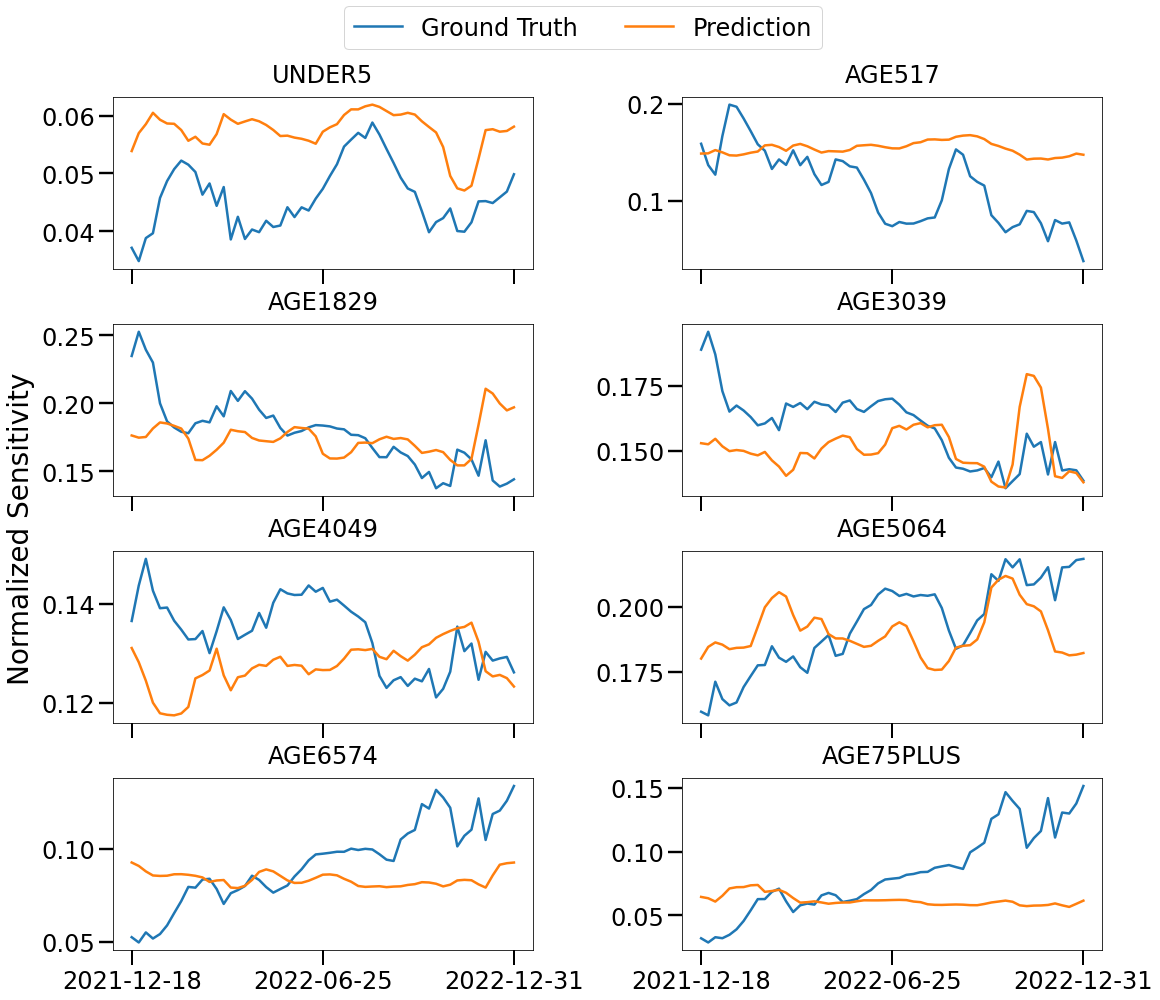

In [171]:
fig, axes = plt.subplots(
    nrows=4, ncols=2, figsize=(16, 13), 
    sharex=True, 
    # sharey=True,
    layout='constrained'
)
dates = group_cases['end_of_week'].values
x_first_tick = dates.min()
x_last_tick = dates.max()
x_major_ticks = 3

for i in range(4):
    for j in range(2):
        age_feature = age_features[i*2 +j]
        axes[i][j].plot(dates, group_cases[age_feature], label='Ground Truth')
        axes[i][j].plot(dates, weekly_agg_scores_df[age_feature], label='Prediction')
        
        axes[i][j].set_title(age_feature)
        axes[i][j].set_xticks(
            [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
        )

fig.supylabel('Normalized Sensitivity', fontsize=28)
Line, Label = axes[0][0].get_legend_handles_labels() 
fig.legend(Line, Label,ncol=2, bbox_to_anchor=(0.72, 1.07))
    
plt.savefig(f'results/attribution_{flag}_ages.jpg', dpi=200, bbox_inches='tight')

## Vaccination

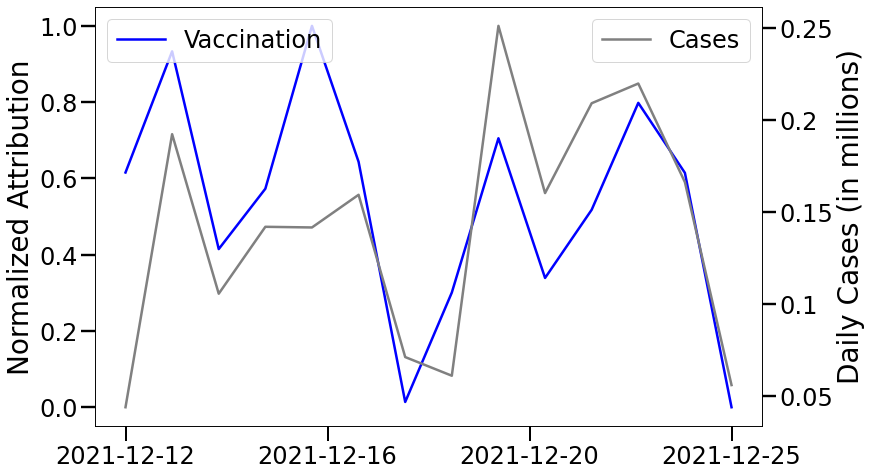

In [44]:
fig, ax = plt.subplots(figsize=(12, 6.5), layout='constrained')
dates = weighted_attr_by_date['Date'].values
vaccination = weighted_attr_by_date['VaccinationFull'].values
vaccination = normalize(vaccination, axis=0)
ax.plot(dates, vaccination, label='Vaccination', color='blue')
ax.legend(loc='upper left')

plt.ylabel('Normalized Attribution')

ax_twin = ax.twinx()
ax_twin.plot(
    dates, cases['Cases'], label='Cases', color='grey'
)
ax_twin.yaxis.set_major_formatter(get_formatter(1e6))
ax_twin.legend(loc='upper right')
ax_twin.set_ylabel(f'Daily Cases (in millions)')

x_first_tick = dates.min()
x_last_tick = dates.max()
x_major_ticks = 4
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)

# fig.tight_layout()     
plt.savefig(f'results/attribution_{flag}_vaccination.jpg', dpi=200)

## Individual age feature

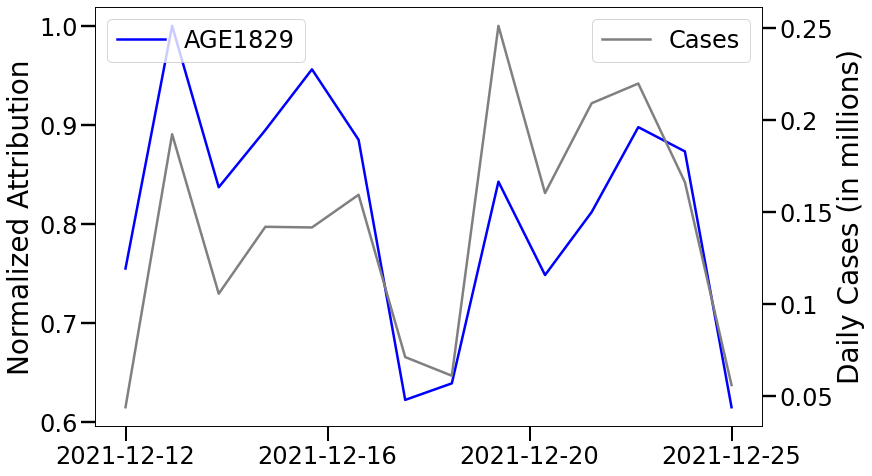

In [45]:
fig, ax = plt.subplots(figsize=(12, 6.5), layout='constrained')
dates = weighted_attr_by_date['Date'].values

age_feature = 'AGE1829'
Y = weighted_attr_by_date[age_feature].values
Y = Y / Y.max()
ax.plot(dates, Y, label=age_feature, color='blue')
ax.legend(loc='upper left')

plt.ylabel('Normalized Attribution')

ax_twin = ax.twinx()
ax_twin.plot(
    dates, cases['Cases'], label='Cases', color='grey'
)
ax_twin.yaxis.set_major_formatter(get_formatter(1e6))
ax_twin.legend(loc='upper right')
ax_twin.set_ylabel(f'Daily Cases (in millions)')

x_first_tick = dates.min()
x_last_tick = dates.max()
x_major_ticks = 4
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)

# fig.supylabel('Normalized Sensitivity Score', fontsize=28)
# axes[0][0].legend(ncol=2)

# fig.tight_layout()     
plt.savefig(f'results/attribution_{flag}_{age_feature}.jpg', dpi=200)

## Single Example

Text(0.5, 0.01, 'Position Index')

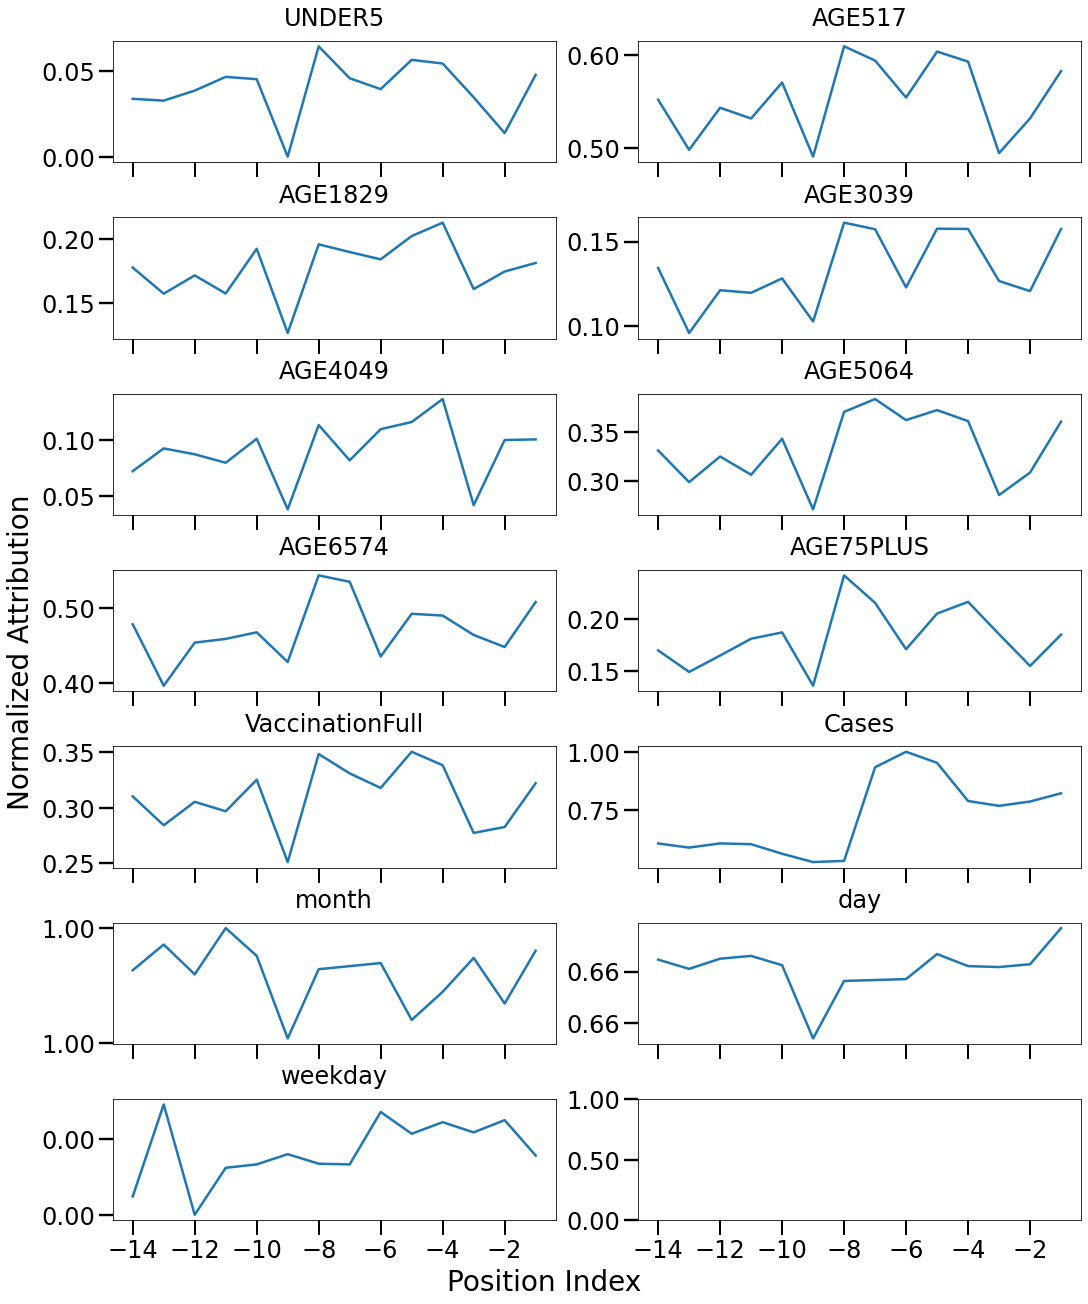

In [32]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 18), sharex=True, layout='constrained')

fips = 6037  # California, Los Angeles
# index = predictions_index[predictions_index['FIPS']==fips].index[0]
index = 11
Y = attr[0][index].mean(axis=0)
Y = (Y - Y.min())/(Y.max()-Y.min())

for i in range(4):
    for j in range(2):
        age_feature = age_features[i*2 +j]
        
        axes[i][j].plot(range(-args.seq_len, 0), Y[:, i*2+j])
        axes[i][j].set_title(age_feature)
        # axes[i][j].set_ylim(0, 1)

for j in range(2):
    past_feature = past_features[8+j]
    axes[4][j].plot(range(-args.seq_len, 0), Y[:, 8+j])
    axes[4][j].set_title(past_feature)
    axes[4][j].xaxis.set_major_locator(MultipleLocator(base=2))

Y = attr[1][index].mean(axis=0)
Y = (Y - Y.min())/(Y.max()-Y.min())
for j in range(2):
    known_feature = age_data.known_reals[j]
    axes[5][j].plot(range(-args.seq_len, 0), Y[:, j])
    axes[5][j].set_title(known_feature)
    axes[5][j].xaxis.set_major_locator(MultipleLocator(base=2))
    
known_feature = age_data.known_reals[2]
axes[6][0].plot(range(-args.seq_len, 0), Y[:, 2])
axes[6][0].set_title(known_feature)
axes[6][0].xaxis.set_major_locator(MultipleLocator(base=2))


formatter = StrMethodFormatter("{x:.2f}")
for ax_row in axes:
    for ax in ax_row:
        ax.yaxis.set_major_formatter(formatter)

# fig.tight_layout()   
fig.supylabel('Normalized Attribution', fontsize=28)
fig.supxlabel('Position Index', fontsize=28)
  
# plt.legend(ncol=2, bbox_to_anchor=(0.23, 5.4))
# plt.savefig(f'results/attribution_{flag}_{fips}.jpg', dpi=200, bbox_inches="tight")

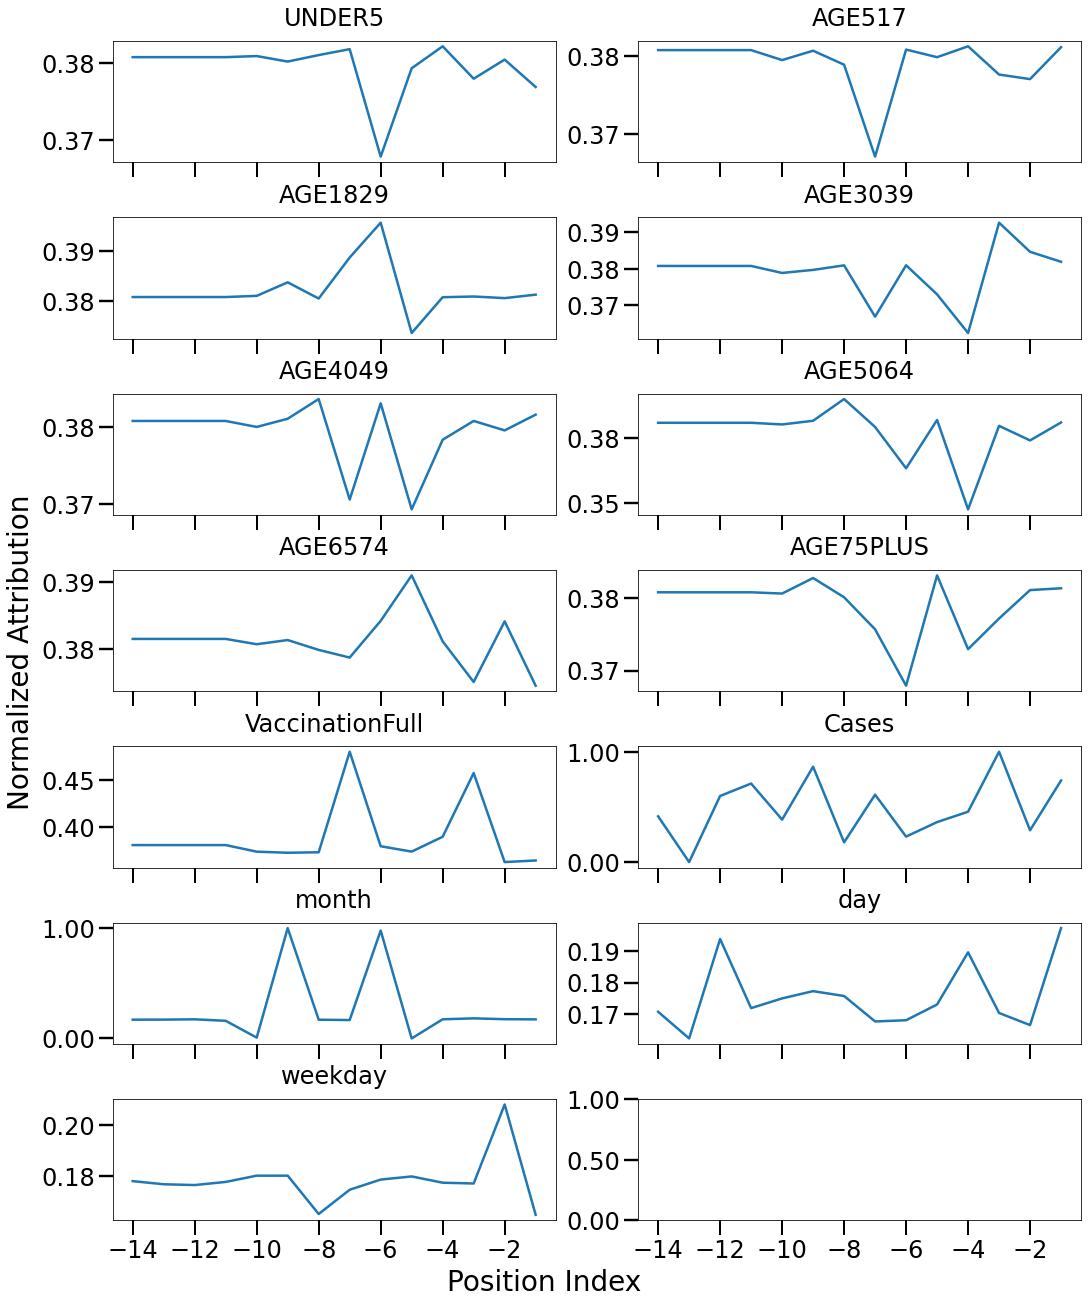

In [49]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 18), sharex=True, layout='constrained')

fips = 6037  # California, Los Angeles
index = predictions_index[predictions_index['FIPS']==fips].index[0]
# index = 1
Y = attr[0][index].mean(axis=0)
Y = (Y - Y.min())/(Y.max()-Y.min())

for i in range(4):
    for j in range(2):
        age_feature = age_features[i*2 +j]
        
        axes[i][j].plot(range(-args.seq_len, 0), Y[:, i*2+j])
        axes[i][j].set_title(age_feature)
        # axes[i][j].set_ylim(0, 1)

for j in range(2):
    past_feature = past_features[8+j]
    axes[4][j].plot(range(-args.seq_len, 0), Y[:, 8+j])
    axes[4][j].set_title(past_feature)
    axes[4][j].xaxis.set_major_locator(MultipleLocator(base=2))

Y = attr[1][index].mean(axis=0)
Y = (Y - Y.min())/(Y.max()-Y.min())
for j in range(2):
    known_feature = age_data.known_reals[j]
    axes[5][j].plot(range(-args.seq_len, 0), Y[:, j])
    axes[5][j].set_title(known_feature)
    axes[5][j].xaxis.set_major_locator(MultipleLocator(base=2))
    
known_feature = age_data.known_reals[2]
axes[6][0].plot(range(-args.seq_len, 0), Y[:, 2])
axes[6][0].set_title(known_feature)
axes[6][0].xaxis.set_major_locator(MultipleLocator(base=2))


formatter = StrMethodFormatter("{x:.2f}")
for ax_row in axes:
    for ax in ax_row:
        ax.yaxis.set_major_formatter(formatter)

# fig.tight_layout()   
fig.supylabel('Normalized Attribution', fontsize=28)
fig.supxlabel('Position Index', fontsize=28)
  
# plt.legend(ncol=2, bbox_to_anchor=(0.23, 5.4))
plt.savefig(f'results/attribution_{flag}_{fips}.jpg', dpi=200, bbox_inches="tight")